In [9]:
import torch
from torch import nn
import numpy as np
import pandas as pd
from torch.optim import Adam, SGD
import torch.nn.functional as F

%matplotlib inline
import matplotlib.pyplot as plt

## Load data

In [10]:
df = pd.read_csv('data_akbilgic.csv')
df = df.drop("date", axis = 1).values

In [11]:
df

array([[ 0.03575371,  0.03837619, -0.00467931, ...,  0.03119023,
         0.01269804,  0.02852446],
       [ 0.02542587,  0.03181274,  0.00778674, ...,  0.01891958,
         0.01134065,  0.00877264],
       [-0.02886173, -0.02635297, -0.03046913, ..., -0.03589858,
        -0.0170728 , -0.02001541],
       ...,
       [ 0.00019097, -0.0016526 ,  0.00192291, ...,  0.00562792,
         0.00057157,  0.00693787],
       [-0.01306904, -0.01370599, -0.02074215, ..., -0.01194168,
        -0.01261533, -0.00095774],
       [-0.00724632, -0.01944185,  0.        , ..., -0.01225155,
        -0.00546489, -0.01429693]])

## Split data

In [12]:
df_size = int(df.shape[0] * 0.8)
df_train = df[: df_size]
df_test = df[df_size :]

## Batchify data

In [13]:
def next_stock_batch(batch_size, n_steps, df_base, n_features):
    t_max = df_base.shape[0]

    x = np.zeros((batch_size, n_steps, n_features))
    y = np.zeros((batch_size, n_steps))
    starting_points = np.random.randint(0, t_max-n_steps-1, size=batch_size)    
    #print(starting_points)
    
    # We create the batches for x using all time series (8) between t and t+n_steps 
    for i, sp in enumerate(starting_points):
        x[i] = df[sp:sp + n_steps]
        y[i] = df[sp + 1: sp + n_steps + 1, 1]

    return x, y

x, y = next_stock_batch(32, 5, df, df.shape[1])

print(x[0])

[[-0.00489556 -0.02057868  0.00644194 -0.01227897 -0.00302053 -0.02600898
   0.00217772 -0.01182285 -0.00972294]
 [ 0.01319904  0.02529305  0.01286014  0.00990584  0.00556926  0.01206537
   0.01963906  0.01236026  0.00297106]
 [ 0.00435622  0.00875744 -0.01678774 -0.00149993 -0.01154778  0.
  -0.00661218 -0.00606873  0.0041647 ]
 [-0.0095245  -0.01784133  0.0130352   0.00507535 -0.02593995 -0.03325903
  -0.00610478  0.00086342 -0.00758687]
 [-0.01830306 -0.02159371 -0.02412717 -0.02629737  0.          0.
  -0.03409731 -0.03072235 -0.01250644]]


## Model

In [14]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, batch_size, seq_len):
        super().__init__()
        self.num_layer = num_layers
        self.hidden_size = hidden_size
        self.seq_len = seq_len
        self.batch_size = batch_size

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc1 = nn.Linear(self.batch_size * self.hidden_size, 1024)
        self.fc2 = nn.Linear(1024, self.batch_size * self.seq_len)
    

    def forward(self, x):
        h0 = torch.zeros((self.num_layer, self.batch_size, self.hidden_size))
        c0 = torch.zeros((self.num_layer, self.batch_size, self.hidden_size))

        output, (hn, cn) = self.lstm(x, (h0, c0))
        last_hidden = hn[-1]
    

        x = F.relu(last_hidden.flatten()) # added this line, you can activate also the last hidden layer, for better performance
        x = F.relu(self.fc1(x))
        return self.fc2(x)


model = LSTM(9, 10, 10, 32, 5)

## Train

In [15]:
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr= 0.001)

Epoch: 1/500, MSE: 0.0009749772725626826
Epoch: 51/500, MSE: 0.000478555157314986
Epoch: 101/500, MSE: 0.00035795863368548453
Epoch: 151/500, MSE: 0.0005200784653425217
Epoch: 201/500, MSE: 0.0003813054063357413
Epoch: 251/500, MSE: 0.000358375022187829
Epoch: 301/500, MSE: 0.00040821227594278753
Epoch: 351/500, MSE: 0.00044245662866160274
Epoch: 401/500, MSE: 0.0003530146204866469
Epoch: 451/500, MSE: 0.0005071951309219003


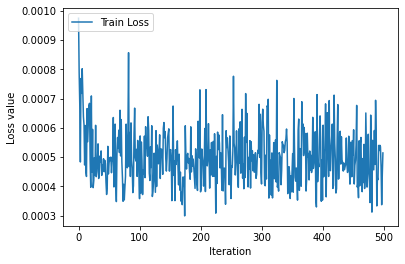

In [16]:
n_iterations = 500
printing_gap = 50
train_loss = []

for iter in range(n_iterations):
    
    model.train()  
    # Get a batch
    x_train, y_train = next_stock_batch(32, 5, df_train, df.shape[1])

    # make into tensor
    x_train = torch.from_numpy(x_train).float()
    y_train = torch.from_numpy(y_train).float().flatten()


    y_pred = model(x_train)
    loss = criterion(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss.append(loss.detach().item())

    

    if iter % printing_gap == 0:
        print(f'Epoch: {iter + 1}/{n_iterations}, MSE: {loss.item()}')

        

plt.plot(train_loss, label= "Train Loss")
plt.xlabel(" Iteration ")
plt.ylabel("Loss value")
plt.legend(loc="upper left")
plt.show()